In [5]:
import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

## Load up helper objects

files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/") # This will update through time. Not nessisary now because focus on 2019
st_id_map = pd.read_csv("/projects/my-public-bucket/fire_weather_vis/ref_data/isd-history.csv") ## For mappting ID's to lat lon

# Helper Variable
stations = fv.st_avail(files, st_id_map = st_id_map, path_s3 ="veda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/")
stations
st_dict = stations[['Lat', 'Lon']].to_dict('records')

Looking for availible stations atveda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/


In [6]:
## For Thomas fire, id is 0 because stored in custom path. Across 2017 and 2018

fireID = '0' # Specific to Thomas fire path
gdf = fv.load_large_fire(fireID, year = "2018", path_region="Thomas")
gdf

Looking for files in ['/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/Thomas/2018/Largefire/F0_20180101AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/Thomas/2018/Largefire/F0_20180101PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/Thomas/2018/Largefire/F0_20180102AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/Thomas/2018/Largefire/F0_20180102PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/Thomas/2018/Largefire/F0_20180103AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/Thomas/2018/Largefire/F0_20180103PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/Thomas/2018/Largefire/F0_20180104AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/Thomas/2018/Largefire/F0_20180104PM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/Thomas/2018/Largefire/F0_20180105AM', '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/Thomas/2018/Larg

/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:371: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf = gdf.to_crs('EPSG:4326')
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:372: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x


,n_pixels,n_newpixels,farea,fperim,flinelen,duration,pixden,meanFRP,t,geometry,lon,lat
0,1929,480,376.318515,94.081343,44.265590,0.5,5.125977,75.582333,2017-12-05 12:00:00,"POLYGON ((-119.27724 34.27983, -119.27631 34.2...",-119.145970,34.368039
1,1449,1449,278.155930,80.526373,76.432527,0.0,5.209308,19.391629,2017-12-05 00:00:00,"POLYGON ((-119.27726 34.27967, -119.27724 34.2...",-119.129636,34.359356
2,3816,678,582.770896,159.018885,71.759202,2.0,6.548028,28.824676,2017-12-07 00:00:00,"POLYGON ((-119.27621 34.28519, -119.27613 34.2...",-119.159459,34.390847
3,4125,309,620.655298,174.391696,56.248701,2.5,6.646201,56.477799,2017-12-07 12:00:00,"MULTIPOLYGON (((-119.27591 34.28564, -119.2757...",-119.162605,34.395809
4,3138,277,485.849508,118.643452,28.902547,1.5,6.458790,82.096390,2017-12-06 12:00:00,"POLYGON ((-119.27627 34.28503, -119.27621 34.2...",-119.152853,34.377847
...,...,...,...,...,...,...,...,...,...,...,...,...
90,9135,263,1286.500534,200.481628,43.217869,11.5,7.100658,136.063612,2017-12-16 12:00:00,"POLYGON ((-119.29366 34.30729, -119.29371 34.3...",-119.249662,34.435689
91,9161,26,1288.101669,202.501053,8.739923,12.0,7.112016,2.426923,2017-12-17 00:00:00,"POLYGON ((-119.29371 34.30728, -119.29378 34.3...",-119.250072,34.435741
92,9235,74,1292.792093,202.346343,10.435023,12.5,7.143453,42.147297,2017-12-17 12:00:00,"POLYGON ((-119.29378 34.30727, -119.29383 34.3...",-119.249706,34.436153
93,9253,18,1293.248522,202.203816,1.893177,13.0,7.154851,11.685556,2017-12-18 00:00:00,"POLYGON ((-119.29383 34.30726, -119.29387 34.3...",-119.249656,34.436194


In [7]:
foi = gdf
foi = foi.rename(columns = {"lat": "Lat", "lon": "Lon"})
foi = foi.iloc[0] # First element
foi

n_pixels                                                    1929
n_newpixels                                                  480
farea                                                 376.318515
fperim                                                 94.081343
flinelen                                                44.26559
duration                                                     0.5
pixden                                                  5.125977
meanFRP                                                75.582333
t                                            2017-12-05 12:00:00
geometry       POLYGON ((-119.27724294711965 34.2798286805223...
Lon                                                   -119.14597
Lat                                                    34.368039
Name: 0, dtype: object

In [10]:
st_cls = fv.closest(st_dict, foi)
print(st_cls["Lat"], st_cls["Lon"])
## Get station Data
st = fv.get_st(lat = st_cls["Lat"], lon = st_cls["Lon"], stations = stations)

#gdf = gdf.sort_values(by = ['t']) ## Need to sort or timeseries jumps around
#gdf['t'] = gdf['t'].astype('datetime64[ns]')

full_fr = fv.fr_st_merge(gdf, st, sub = True)
full_fr

The closest station is 18.255971948050192 km away.
34.211 -119.088


/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:127: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)


,n_pixels,n_newpixels,farea,fperim,flinelen,duration,pixden,meanFRP,t,geometry,...,DC,BUI,ISI,FWI,OBSMINUTEDIFFTEMP,OBSMINUTEDIFFRH,OBSMINUTEDIFFWDSPD,OBSMINUTEDIFFPREC,OBSMINUTEDIFFSNOW,HH_format
0,1929.0,480.0,376.318515,94.081343,44.265590,0.5,5.125977,75.582333,2017-12-05 12:00:00,"POLYGON ((-119.27724 34.27983, -119.27631 34.2...",...,1651.2,641.40,130.0000,179.390,5.0,5.0,5.0,5,NaN,12
1,1449.0,1449.0,278.155930,80.526373,76.432527,0.0,5.209308,19.391629,2017-12-05 00:00:00,"POLYGON ((-119.27726 34.27967, -119.27724 34.2...",...,NaN,NaN,112.2100,165.700,5.0,5.0,5.0,5,NaN,00
2,3816.0,678.0,582.770896,159.018885,71.759202,2.0,6.548028,28.824676,2017-12-07 00:00:00,"POLYGON ((-119.27621 34.28519, -119.27613 34.2...",...,NaN,NaN,18.4760,58.813,5.0,5.0,5.0,5,NaN,00
3,4125.0,309.0,620.655298,174.391696,56.248701,2.5,6.646201,56.477799,2017-12-07 12:00:00,"MULTIPOLYGON (((-119.27591 34.28564, -119.2757...",...,1659.7,646.01,156.4800,198.070,5.0,5.0,5.0,5,NaN,12
4,3138.0,277.0,485.849508,118.643452,28.902547,1.5,6.458790,82.096390,2017-12-06 12:00:00,"POLYGON ((-119.27627 34.28503, -119.27621 34.2...",...,1655.5,643.72,90.8070,147.660,5.0,5.0,5.0,5,NaN,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-20 19:00:00,None,...,NaN,NaN,6.3803,23.144,5.0,5.0,5.0,5,NaN,19
1125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-20 20:00:00,None,...,NaN,NaN,6.9187,24.500,5.0,5.0,5.0,5,NaN,20
1126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-20 21:00:00,None,...,NaN,NaN,5.4455,20.672,5.0,5.0,5.0,5,NaN,21
1127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-20 22:00:00,None,...,NaN,NaN,5.0480,19.568,5.0,5.0,5.0,5,NaN,22


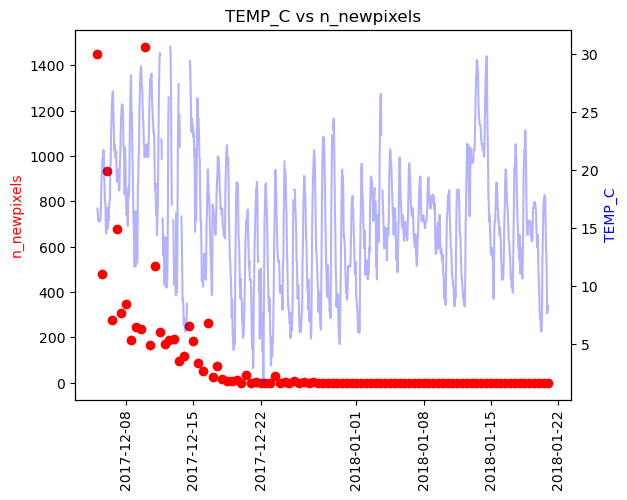

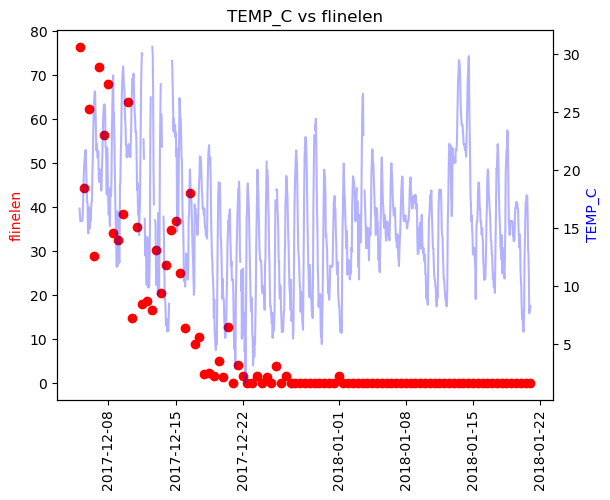

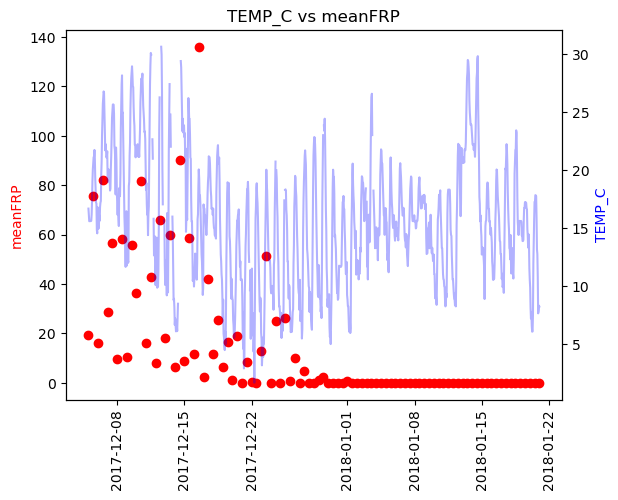

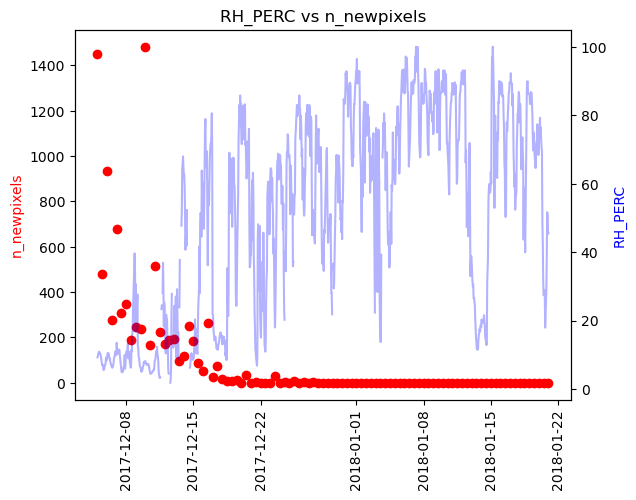

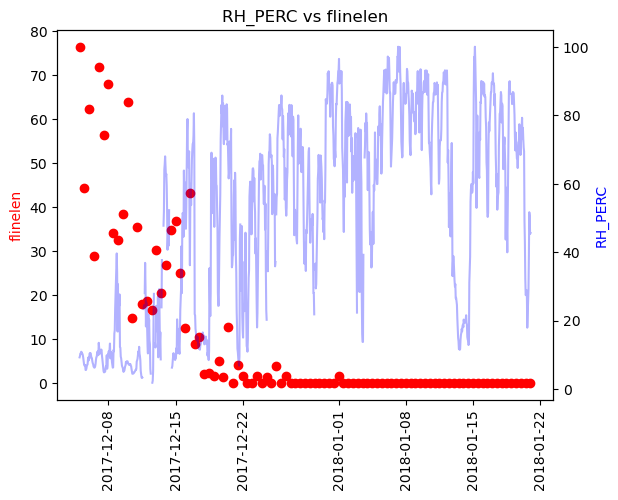

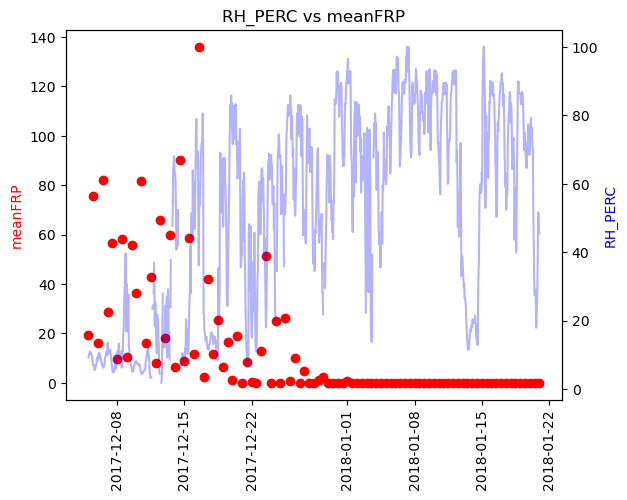

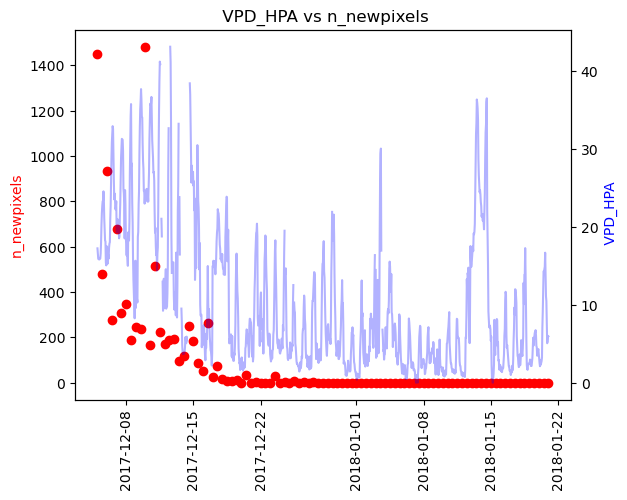

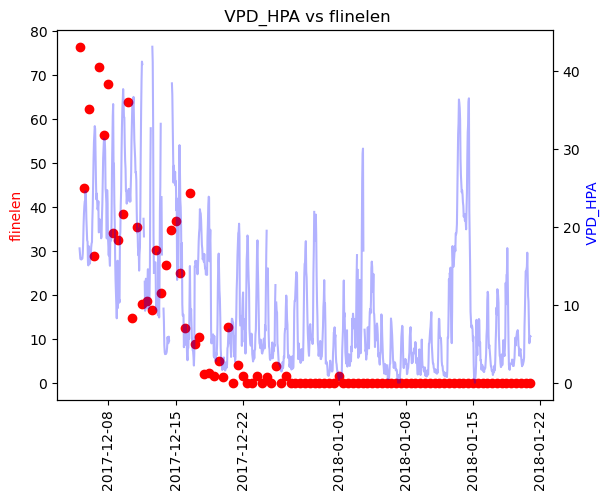

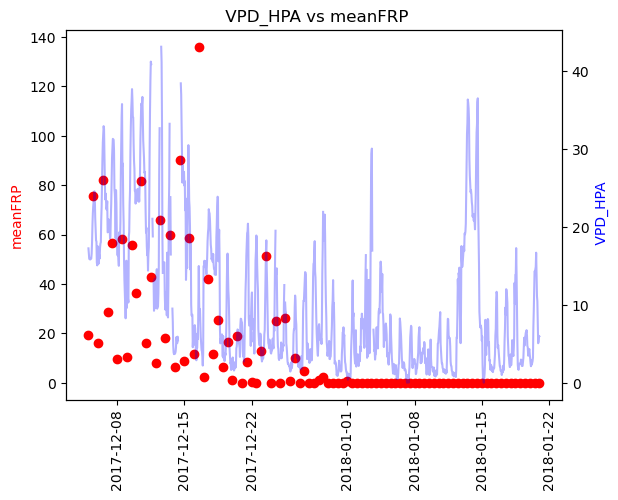

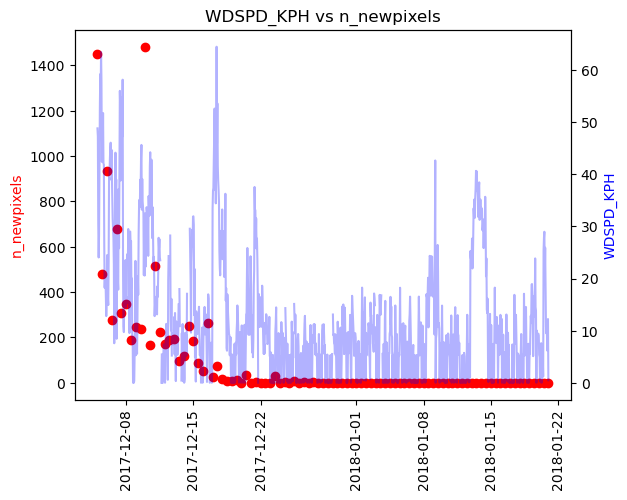

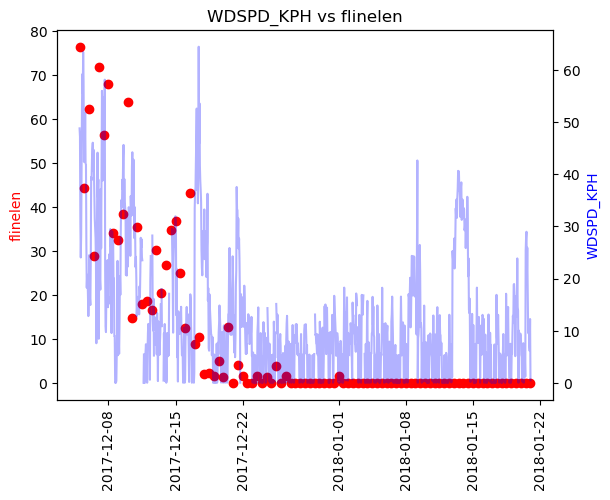

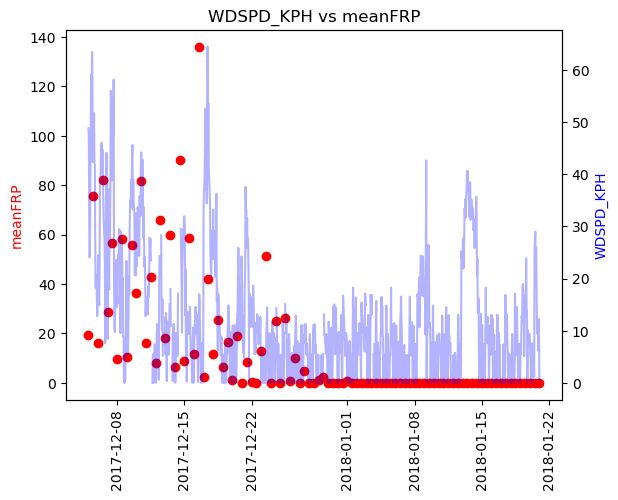

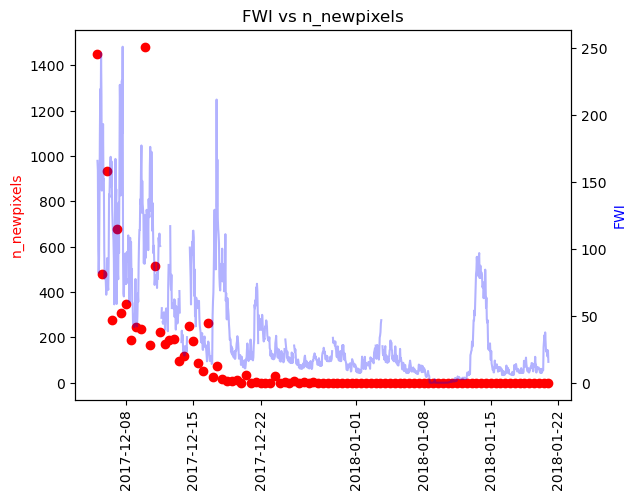

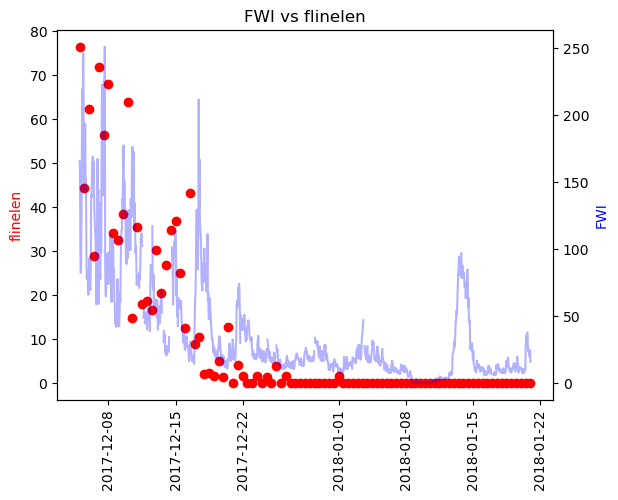

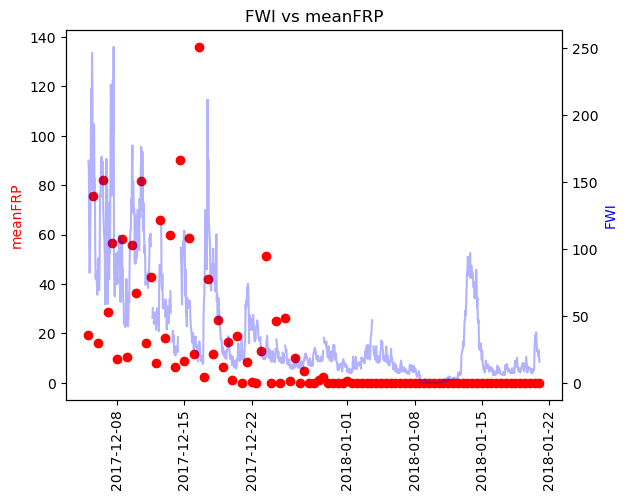

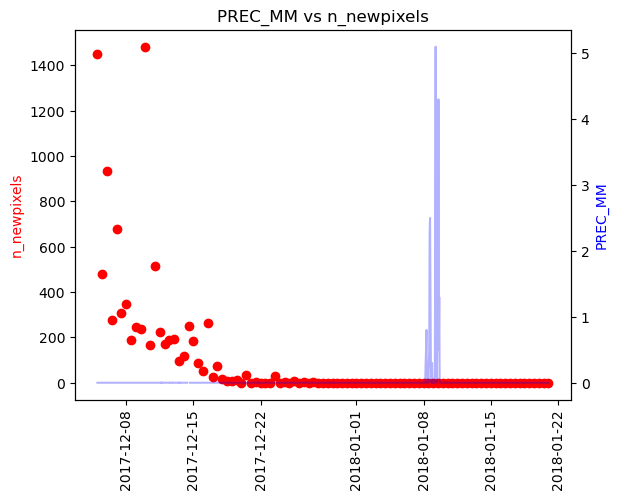

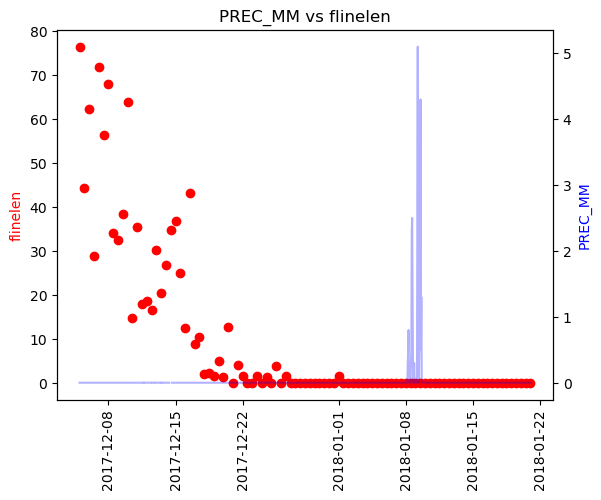

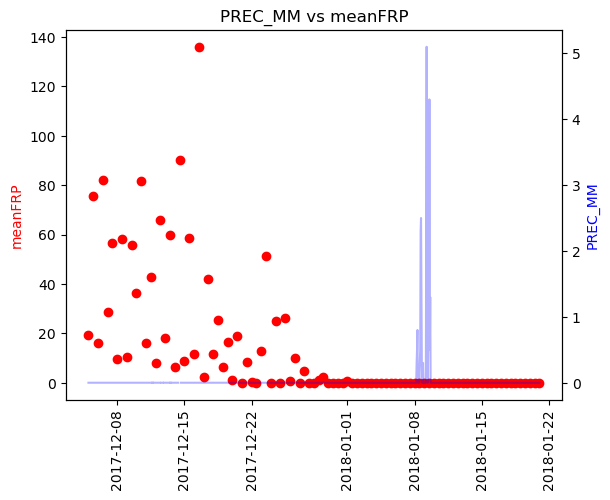

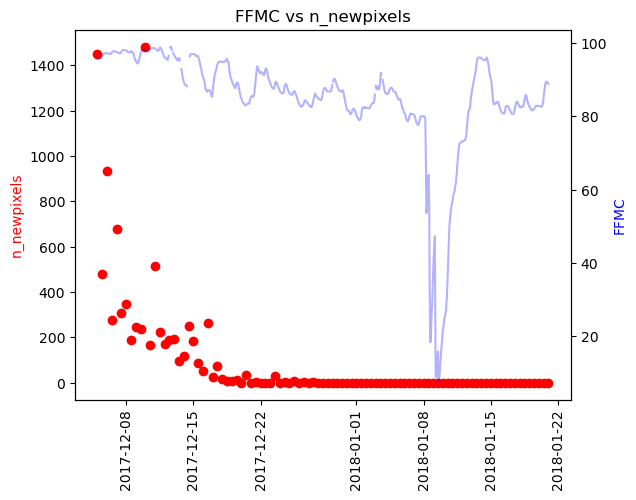

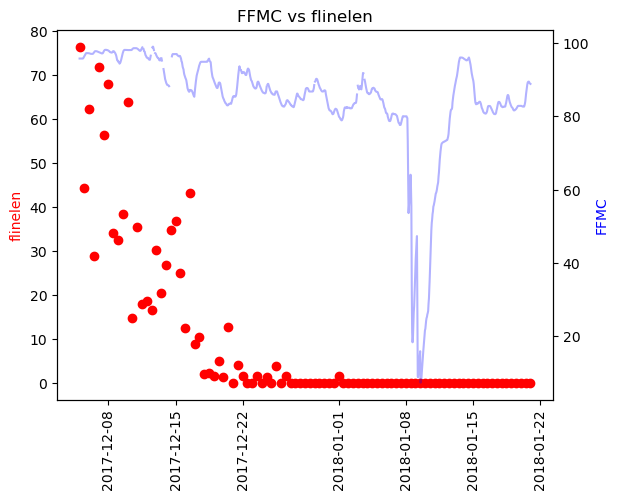

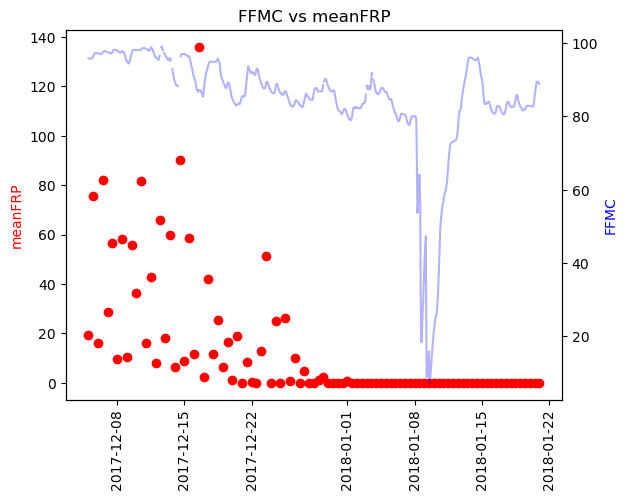

In [19]:
full_fr = full_fr.sort_values(by = ['t']) ## Need to sort or timeseries jumps around
full_fr['t'] = full_fr['t'].astype('datetime64[ns]')

met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM', 'FFMC']  ## Station Data Columns to Plot
fire = [ 'n_newpixels', 'flinelen','meanFRP',] ## gdf columns to plot

#n_met = len(met)
#n_fire = len(fire)

for m in met:
    for f in fire:
        fig, ax = plt.subplots()
        
        ax.scatter(full_fr["t"], full_fr[f], color = "r")
        #ax.plot(full_fr["t"], full_fr[m])
        #plt.xticks(rotation = 90)   
        ax.set_title(m + " vs " +  f)
        ax.set_ylabel(f, color = "red")
        ax2=ax.twinx()
        ax2.plot(full_fr["t"], full_fr[m],color="blue",  alpha=0.3)
        ax2.set_ylabel(m,color="blue")
        ax.tick_params(axis='x', labelrotation = 90)
        #plt.savefig(fname = ("/projects/shared-buckets/ashiklom/thomas_fire_barc/fwi/"+ m + "_vs_" + f+".pdf"))
        #plt.savefig(fname = ("/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/Thomas_fig/"+ m + "_vs_" + f+".pdf"))

        plt.show()

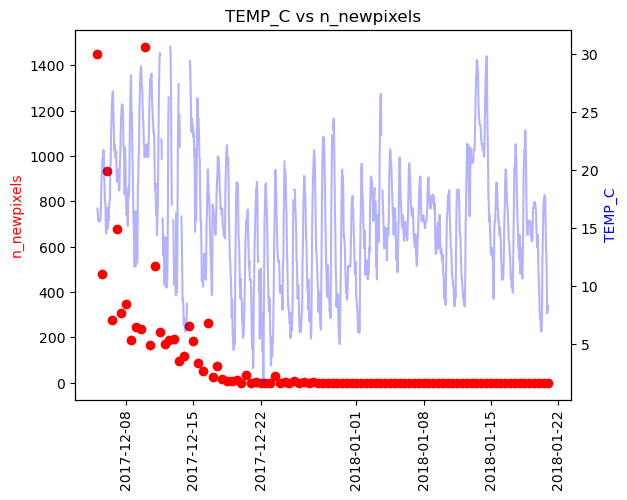

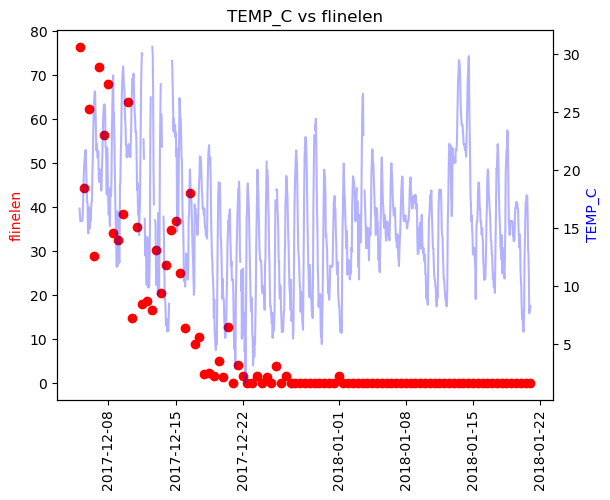

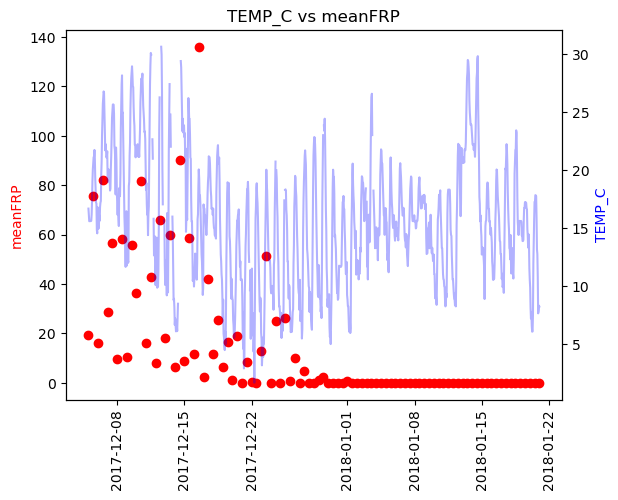

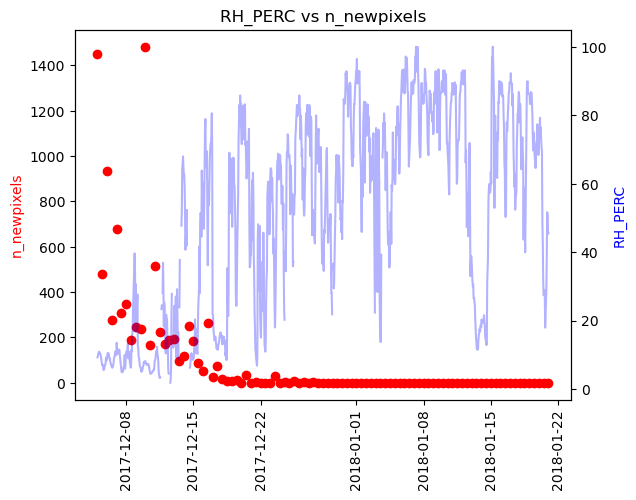

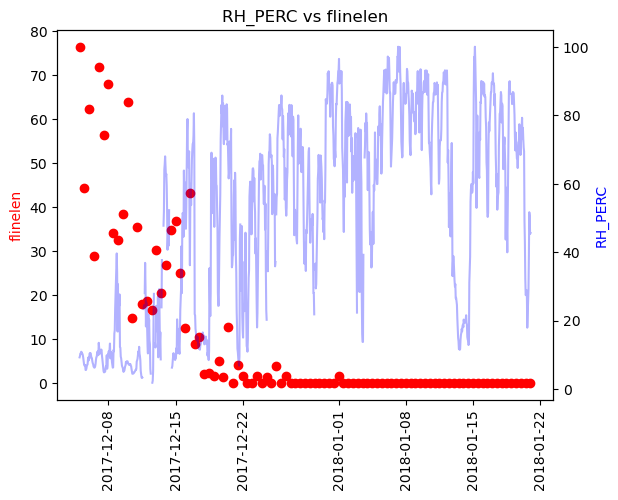

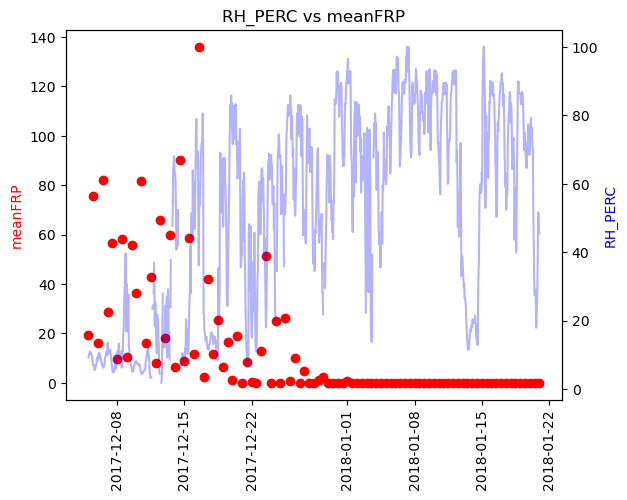

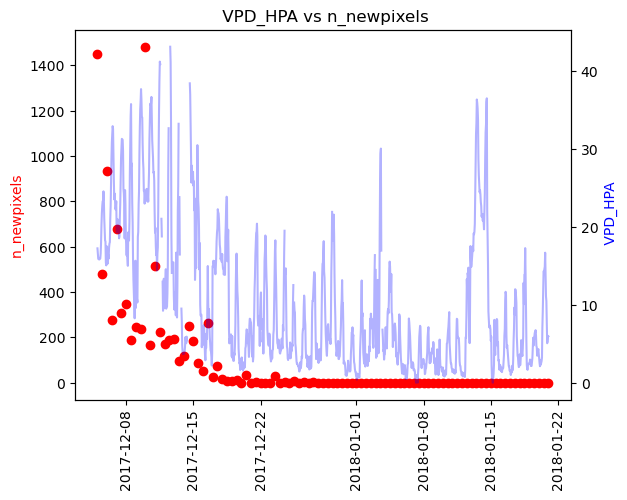

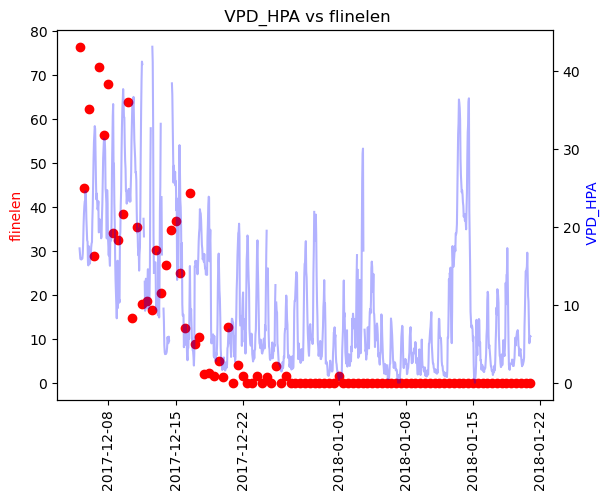

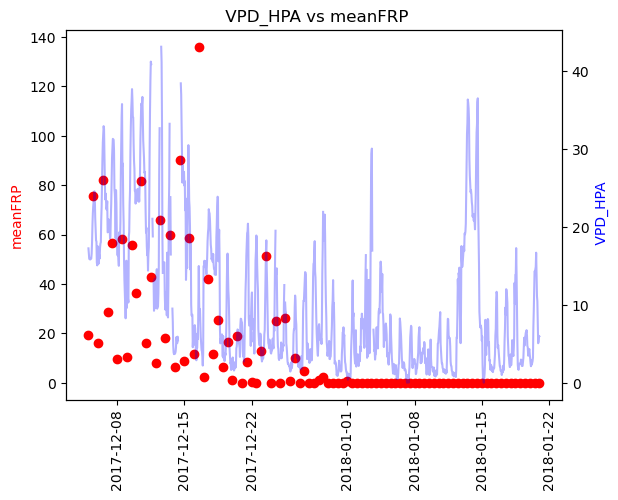

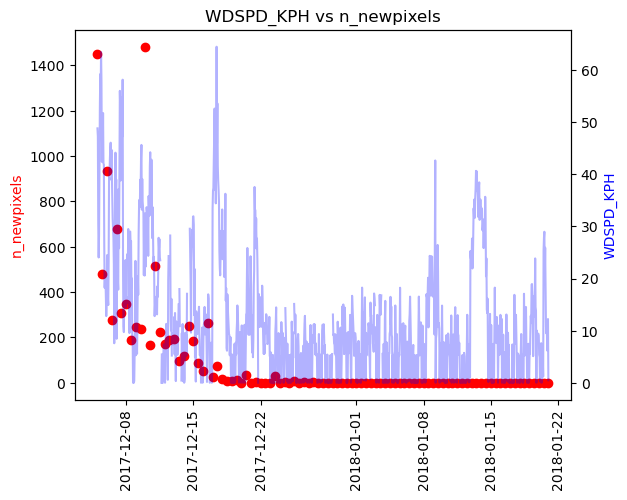

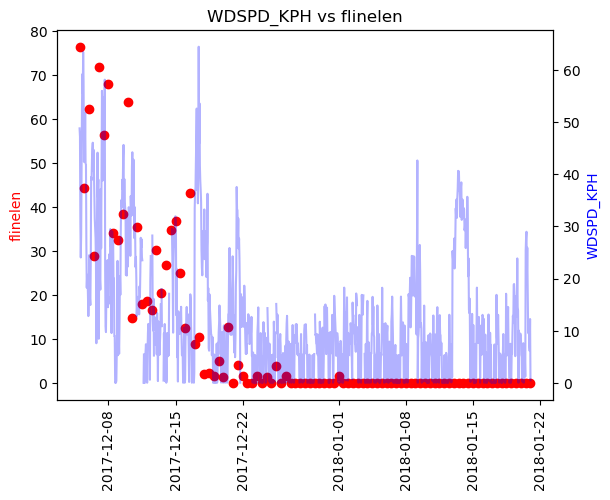

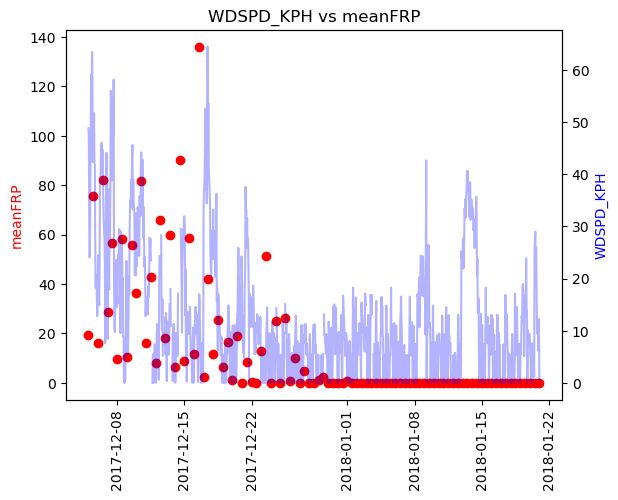

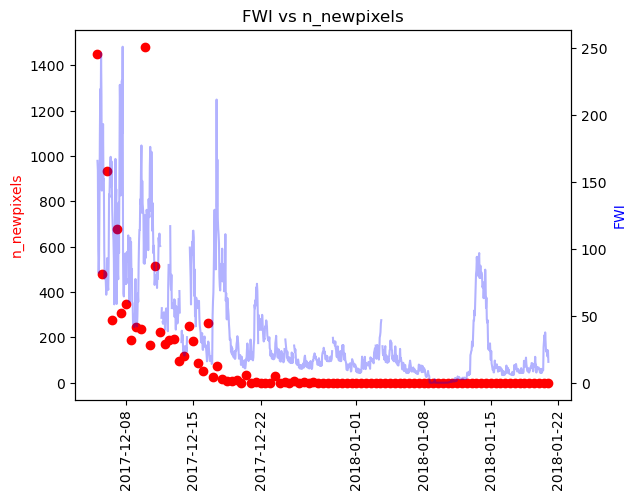

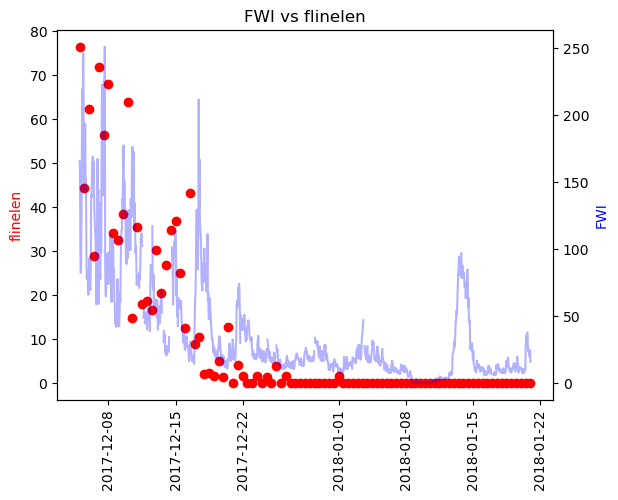

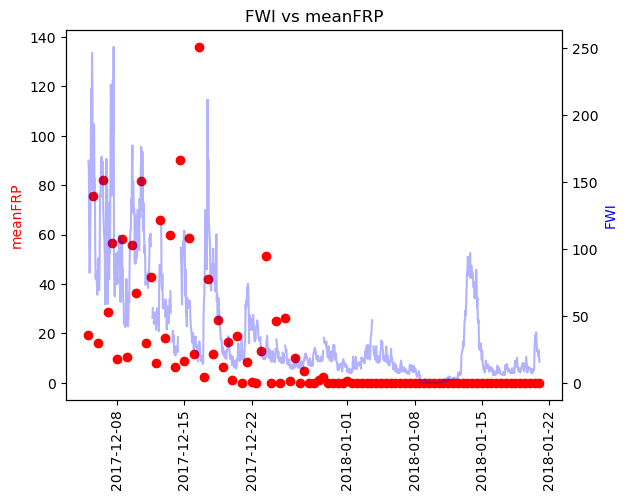

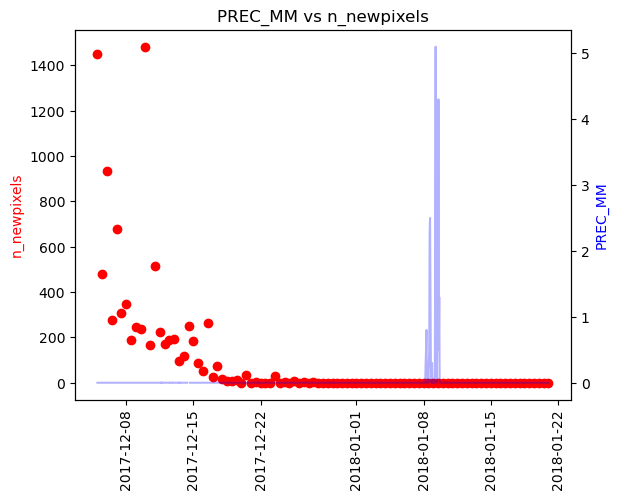

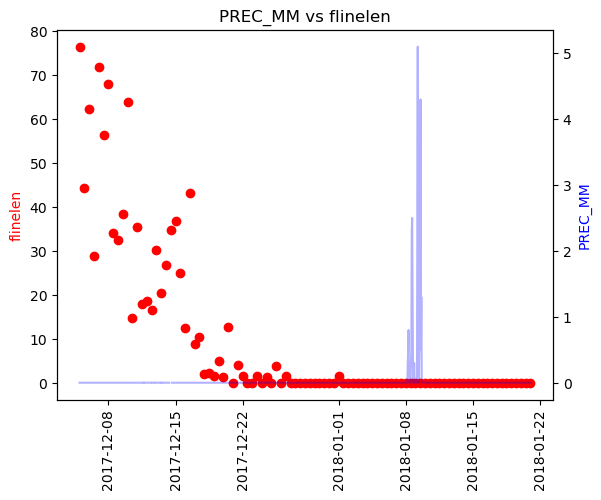

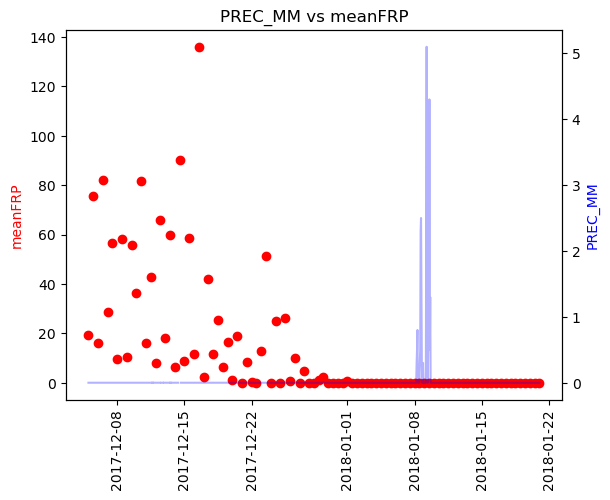

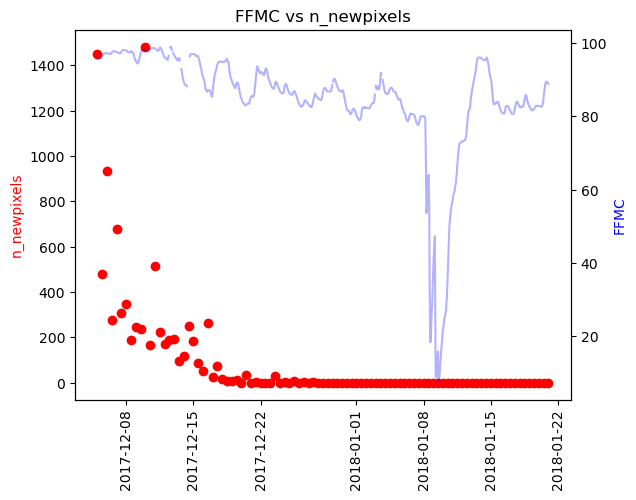

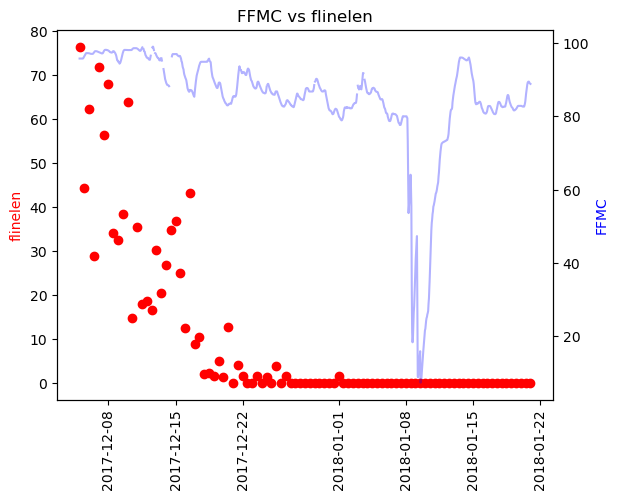

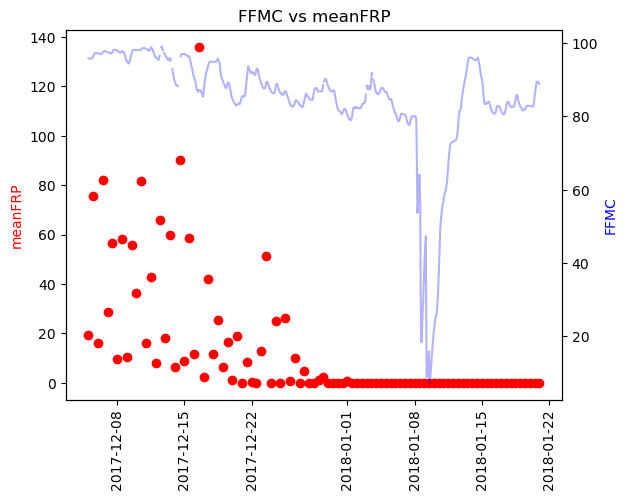

In [9]:
## Export Station data

st.to_csv(path_or_buf= "/projects/shared-buckets/ashiklom/thomas_fire_barc/fwi/Thomas_fwi.csv") #

In [11]:
#plt.savefig

Signature: plt.savefig(*args, **kwargs)
Docstring:
Save the current figure.

Call signature::

  savefig(fname, *, dpi='figure', format=None, metadata=None,
          bbox_inches=None, pad_inches=0.1,
          facecolor='auto', edgecolor='auto',
          backend=None, **kwargs
         )

The available output formats depend on the backend being used.

Parameters
----------
fname : str or path-like or binary file-like
    A path, or a Python file-like object, or
    possibly some backend-dependent object such as
    `matplotlib.backends.backend_pdf.PdfPages`.

    If *format* is set, it determines the output format, and the file
    is saved as *fname*.  Note that *fname* is used verbatim, and there
    is no attempt to make the extension, if any, of *fname* match
    *format*, and no extension is appended.

    If *format* is not set, then the format is inferred from the
    extension of *fname*, if there is one.  If *format* is not
    set and *fname* has no extension, then the file